In [1]:
%matplotlib widget
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import open3d as o3d
import time

from planeslam.general import plot_3D_setup
from utils import dist_filter, spherical_project, bounds_mask

%load_ext autoreload
%autoreload 2

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [40]:
# Landmark location (ground-truth)
LANDMARK_POS = np.array([-2.41, 0.34])
LM_BOX_W = 1.0  # Width of landmark search region box
LM_BOX_XMAX = LANDMARK_POS[0] + LM_BOX_W / 2
LM_BOX_XMIN = LANDMARK_POS[0] - LM_BOX_W / 2
LM_BOX_YMAX = LANDMARK_POS[1] + LM_BOX_W / 2
LM_BOX_YMIN = LANDMARK_POS[1] - LM_BOX_W / 2
LIDAR_HEIGHT = 0.15

x_hat = np.array([0, 0, np.radians(42.5)])  # state estimate (x, y, theta)

In [41]:
LM_BOX_XMAX, LM_BOX_XMIN, LM_BOX_YMAX, LM_BOX_YMIN

(-1.9100000000000001, -2.91, 0.8400000000000001, -0.15999999999999998)

In [2]:
# Load the points
datapath = os.path.join(os.getcwd(), '..', 'data', '5_15_2022', 'fr_config_3')
P = np.load(os.path.join(datapath, 'pc_0.npy'))

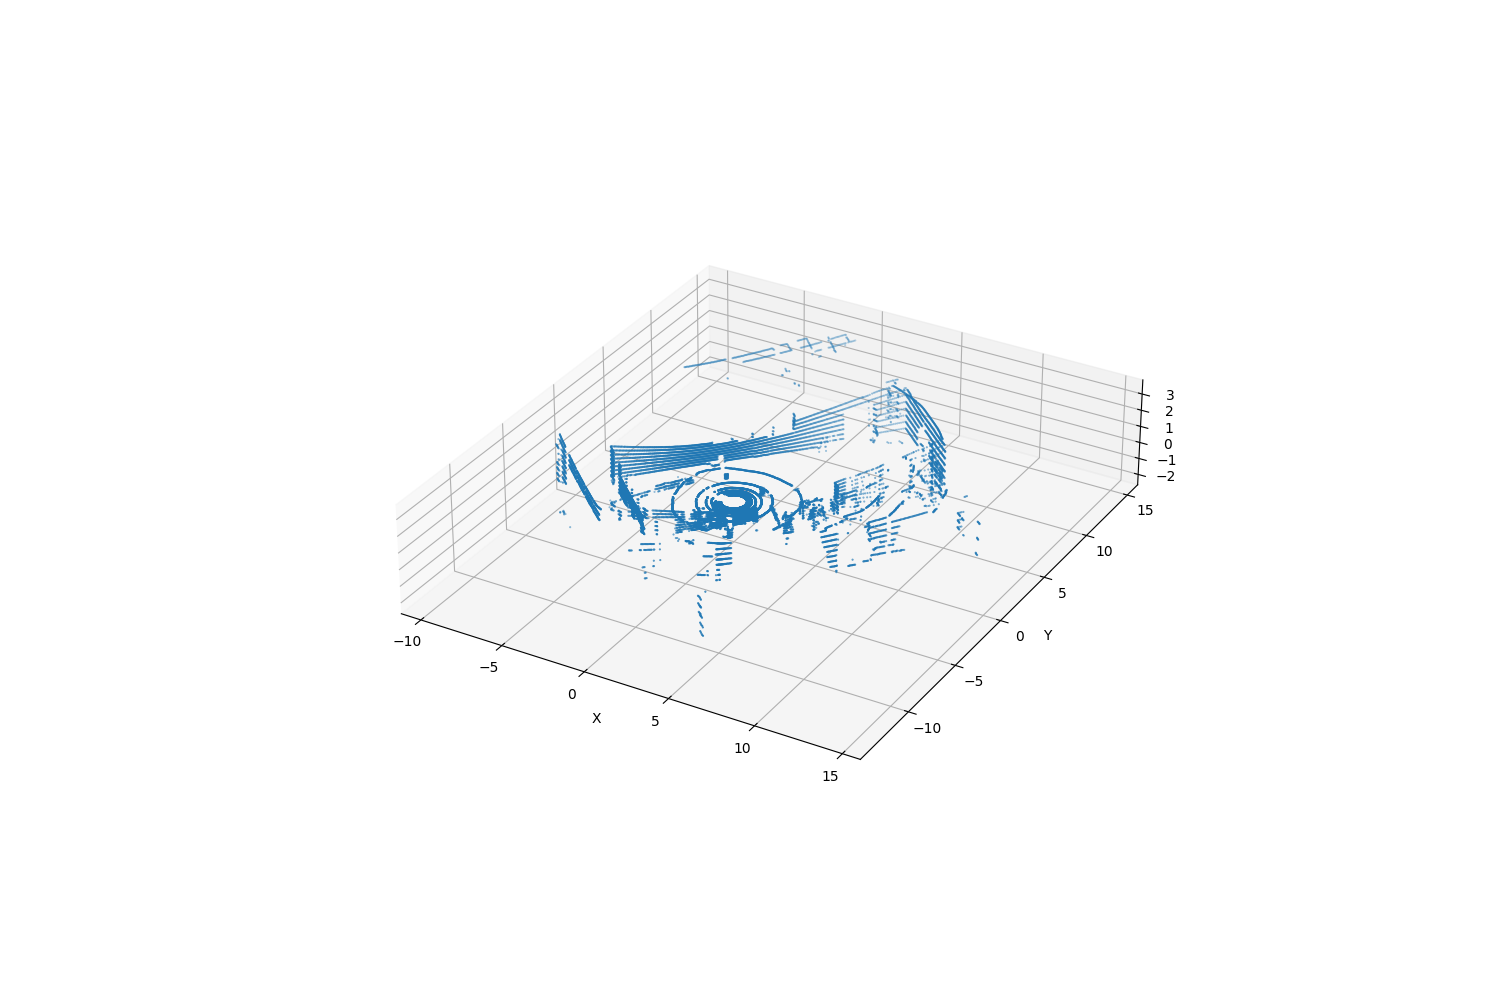

In [3]:
# Plot
ax = plot_3D_setup(P)
ax.scatter3D(P[:,0], P[:,1], P[:,2], s=1, marker='.') 

In [4]:
# Distance filter
P_filter = dist_filter(P, 6)

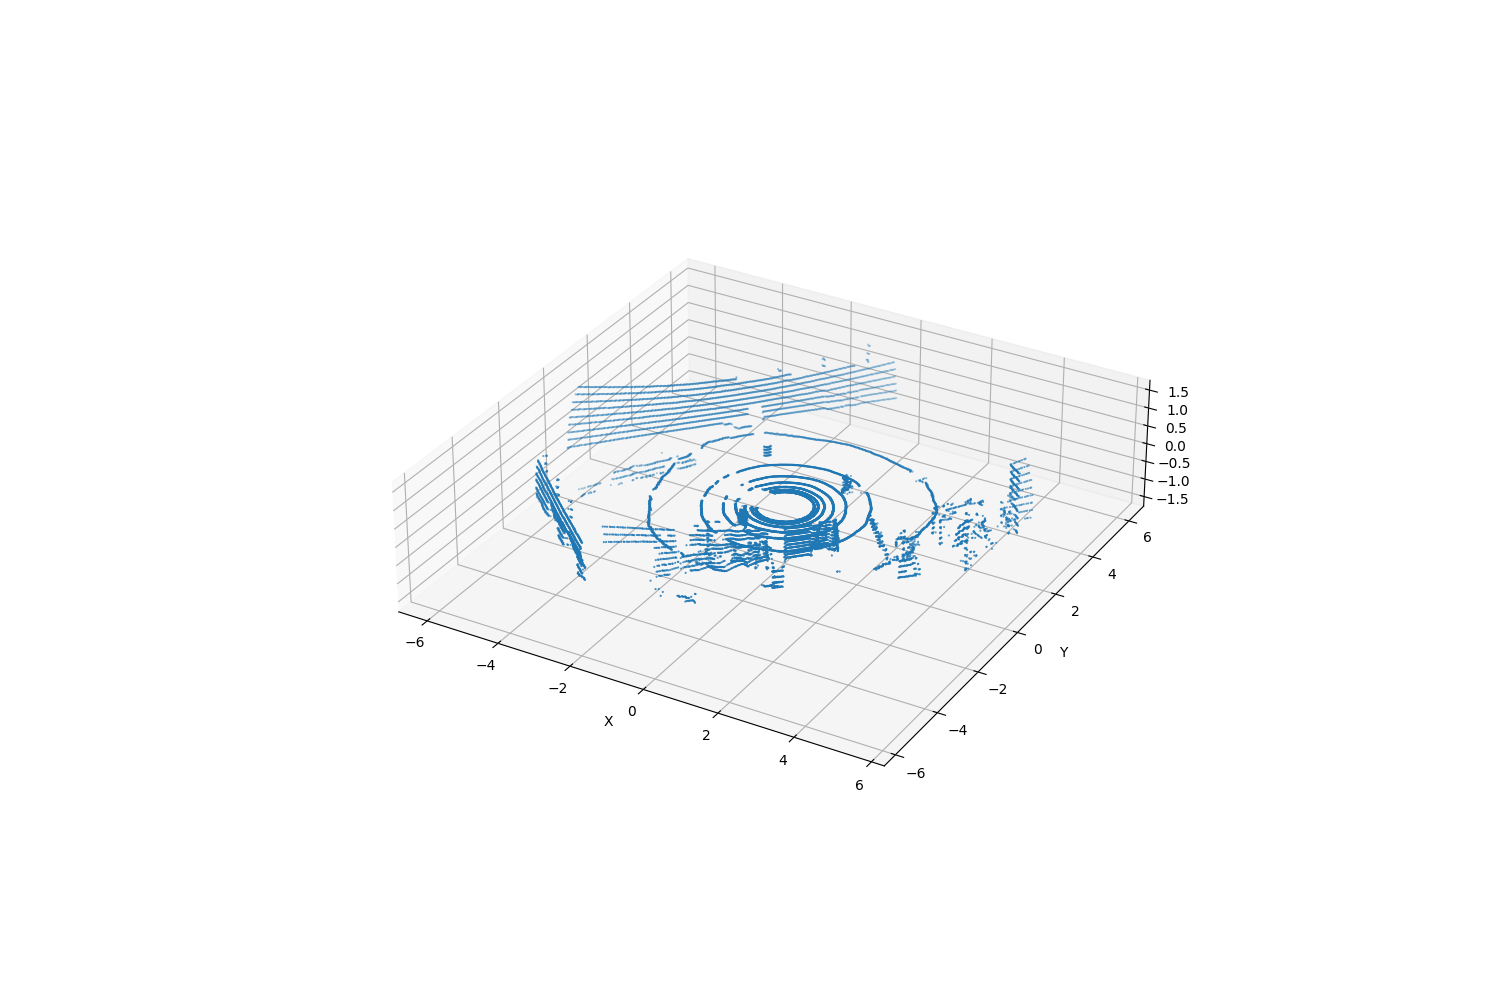

In [5]:
# Plot
ax = plot_3D_setup(P_filter)
ax.scatter3D(P_filter[:,0], P_filter[:,1], P_filter[:,2], s=1, marker='.') 

In [6]:
# Ground removal
P_filter = P_filter[P_filter[:,2] > -LIDAR_HEIGHT,:] 

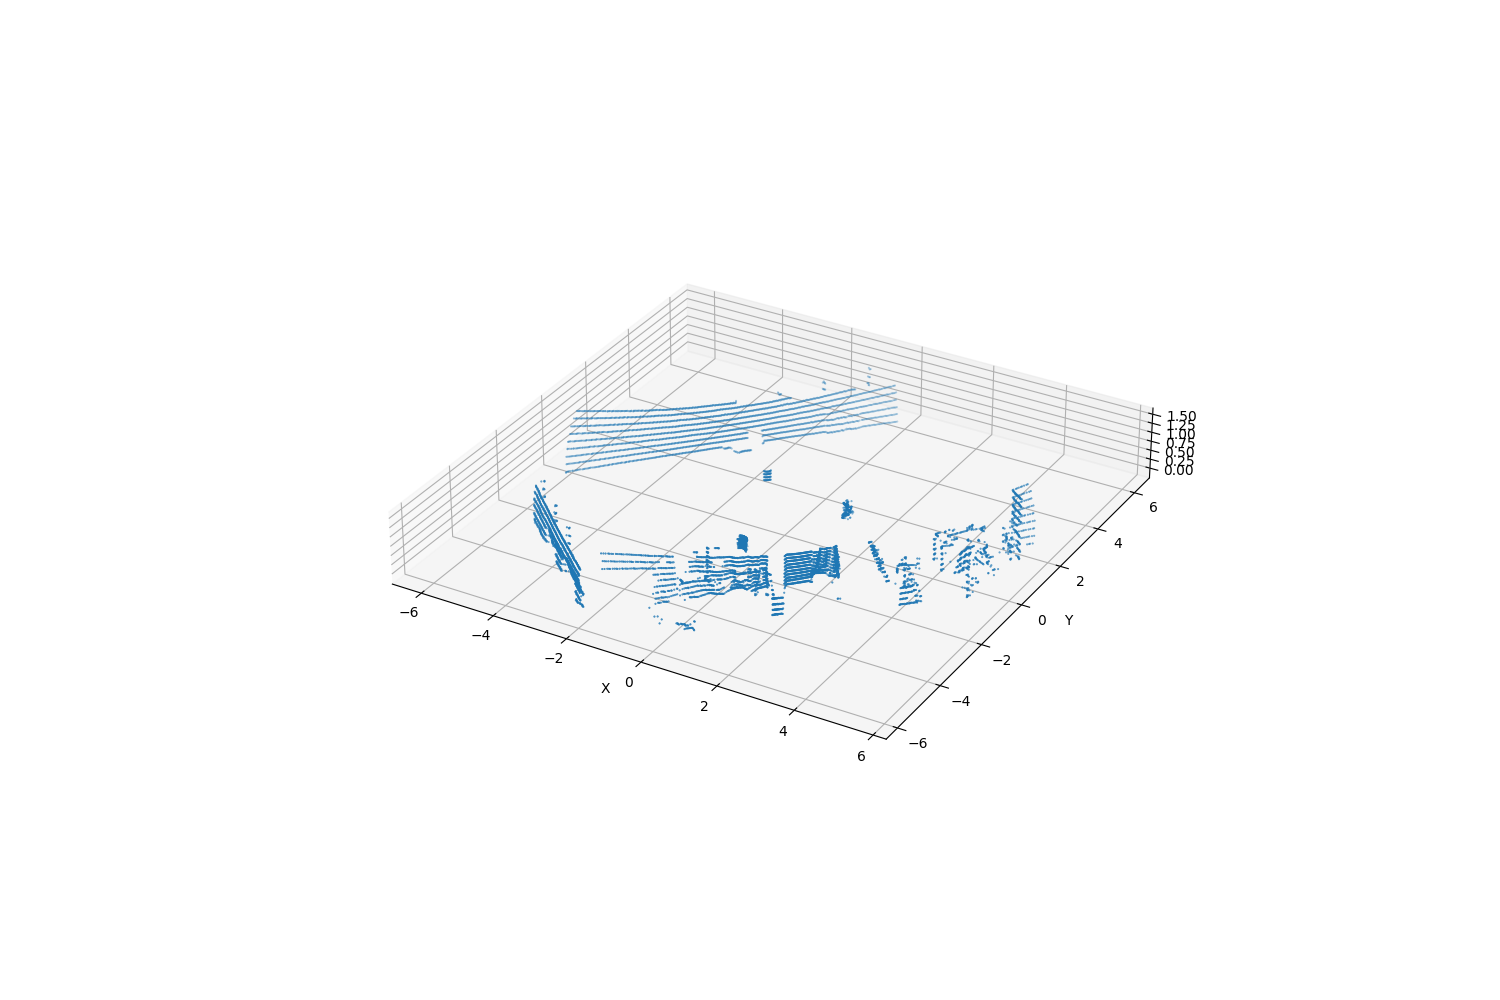

In [7]:
# Plot
ax = plot_3D_setup(P_filter)
ax.scatter3D(P_filter[:,0], P_filter[:,1], P_filter[:,2], s=1, marker='.') 

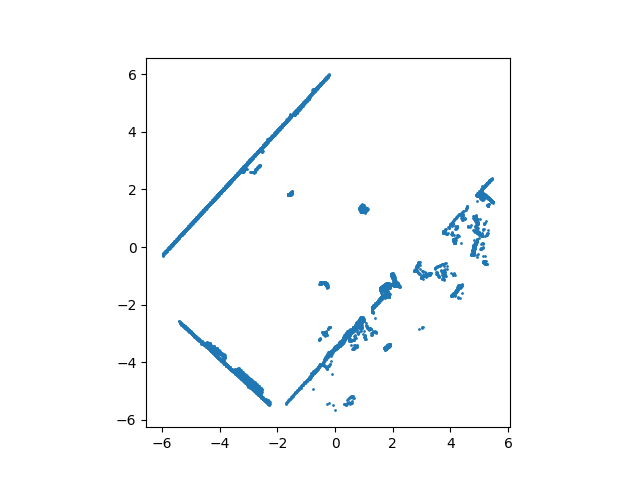

In [8]:
# Background (Wall) Removal
# Extract 2D
P_filter_2D = P_filter[:,:2]

fig, ax = plt.subplots()
ax.scatter(P_filter_2D[:,0], P_filter_2D[:,1], s=1)
ax.set_aspect('equal')

In [20]:
# Orient 2D cloud
heading = x_hat[2]
R = np.array([[np.cos(heading), -np.sin(heading)],
              [np.sin(heading), np.cos(heading)]])
P_filter_2D_rot = (R @ P_filter_2D.T).T

In [23]:
# Shift to global frame (using state estimate)
P_2D_global = P_filter_2D_rot + x_hat[:2]

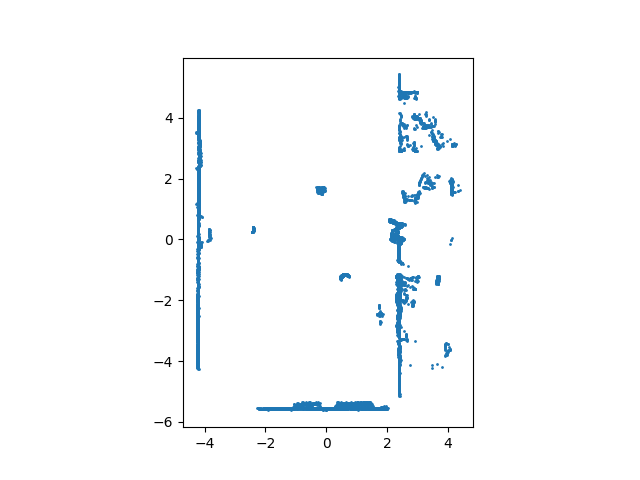

In [46]:
fig, ax = plt.subplots()
ax.scatter(P_2D_global[:,0], P_2D_global[:,1], s=1)
ax.set_aspect('equal')

In [47]:
# Use search region to extract landmark in global frame
mask = np.ones(len(P_filter), dtype=bool)
mask = mask & ((P_2D_global[:,0] <= LM_BOX_XMAX) & (P_2D_global[:,0] >= LM_BOX_XMIN))
mask = mask & ((P_2D_global[:,1] <= LM_BOX_YMAX) & (P_2D_global[:,1] >= LM_BOX_YMIN))

In [51]:
landmark_pts = P_filter[mask]
non_landmark_pts = P_filter[~mask]

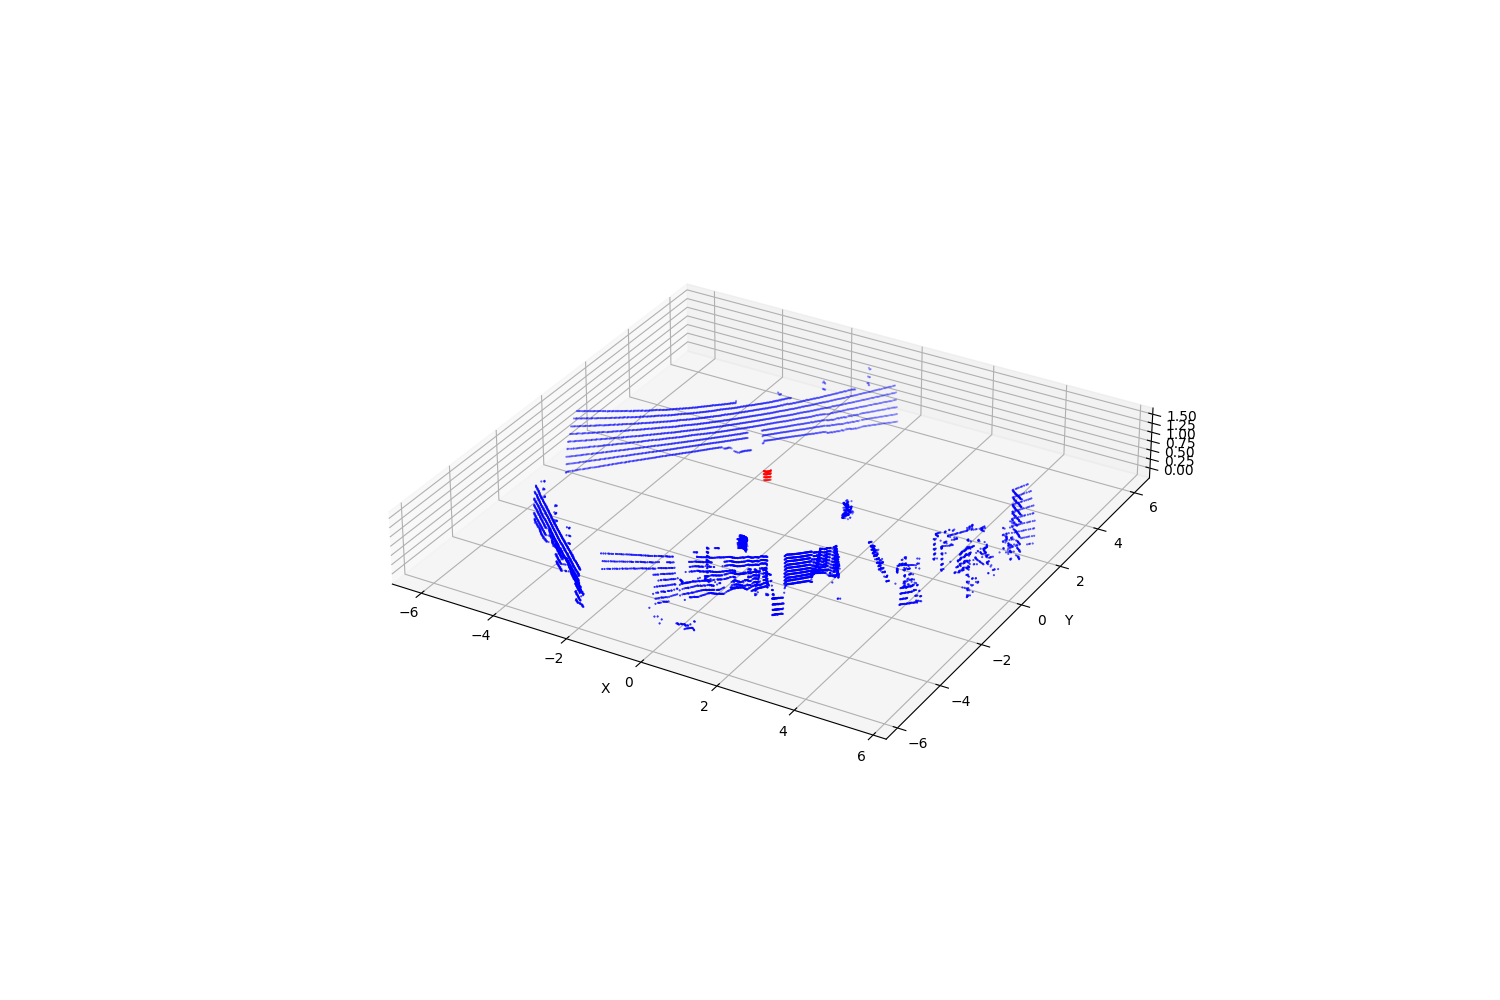

In [53]:
ax = plot_3D_setup(P_filter)
ax.scatter3D(non_landmark_pts[:,0], non_landmark_pts[:,1], non_landmark_pts[:,2], color='b', marker='.', s=1)  
ax.scatter3D(landmark_pts[:,0], landmark_pts[:,1], landmark_pts[:,2], color='r', marker='.', s=1)  

In [12]:
wall = bounds_mask(P_filter_2D_rot)
P_filter_2D_wall = P_filter_2D_rot[wall]
P_filter_2D_wallrm = P_filter_2D_rot[~wall]

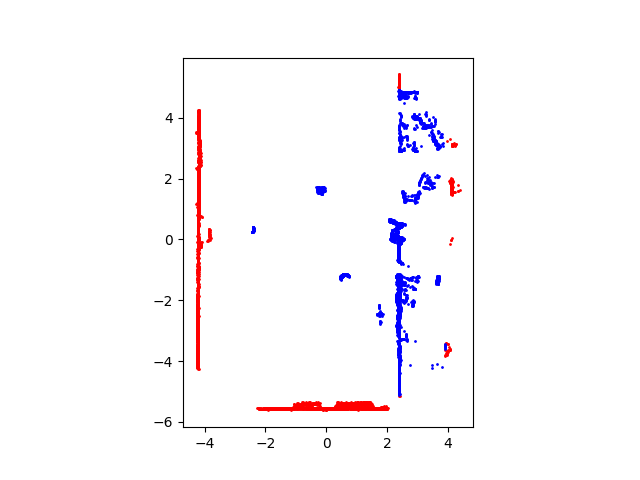

In [13]:
fig, ax = plt.subplots()
ax.scatter(P_filter_2D_wall[:,0], P_filter_2D_wall[:,1], color='r', s=1)
ax.scatter(P_filter_2D_wallrm[:,0], P_filter_2D_wallrm[:,1], color='b', s=1)
ax.set_aspect('equal')

In [15]:
# DBSCAN clustering
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(P_filter)

In [16]:
start_time = time.time()
labels = np.array(pcd.cluster_dbscan(eps=0.2, min_points=10, print_progress=True))
print(time.time() - start_time)
clusters = [[] for _ in range(labels.max()+1)]
for i in range(len(labels)):
    if labels[i] >= 0:
        clusters[labels[i]].append(i)

0.07679390907287598


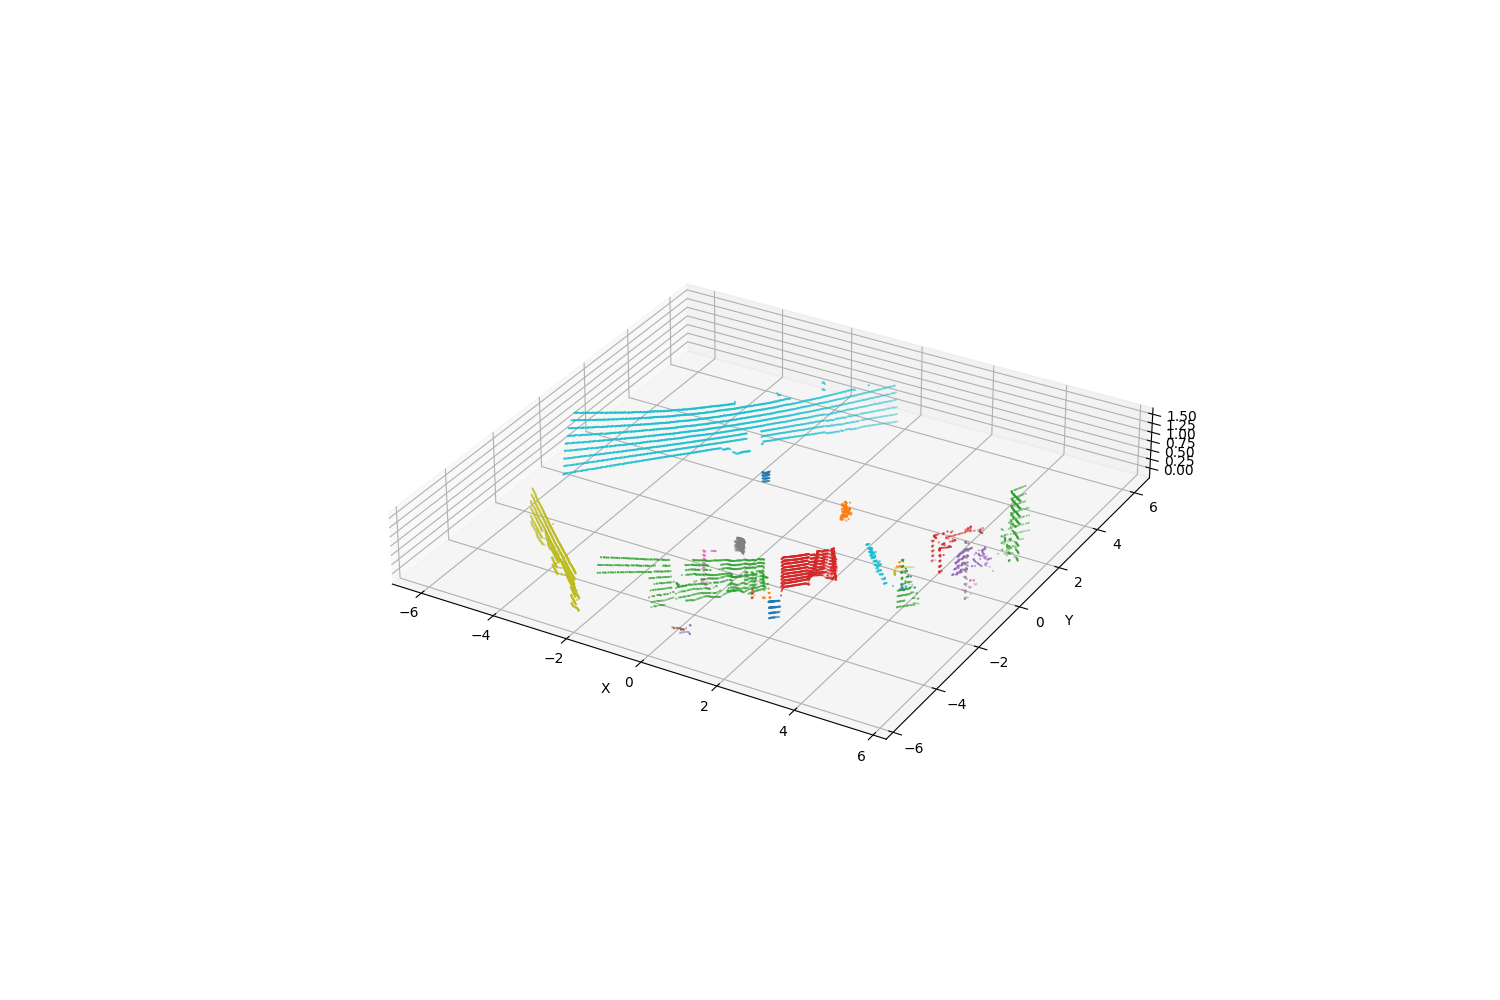

In [17]:
# Plot
ax = plot_3D_setup(P_filter)

color_idx = 0

for i, c in enumerate(clusters):
    cluster_pts = P_filter[c,:]
    ax.scatter3D(cluster_pts[:,0], cluster_pts[:,1], cluster_pts[:,2], s=1, color='C'+str(color_idx), marker='.')  
    color_idx += 1

In [12]:
# Cluster centroids
cluster_centroids = [np.mean(P_filter[c], axis=0) for c in clusters]
cluster_centroids = np.asarray(cluster_centroids)

# Sort by distance
cluster_dists = np.linalg.norm(cluster_centroids, axis=1)

In [13]:
num_landmarks = 4
landmark_cluster_idxs = np.argsort(cluster_dists)[:num_landmarks]
landmark_clusters = [clusters[i] for i in landmark_cluster_idxs]

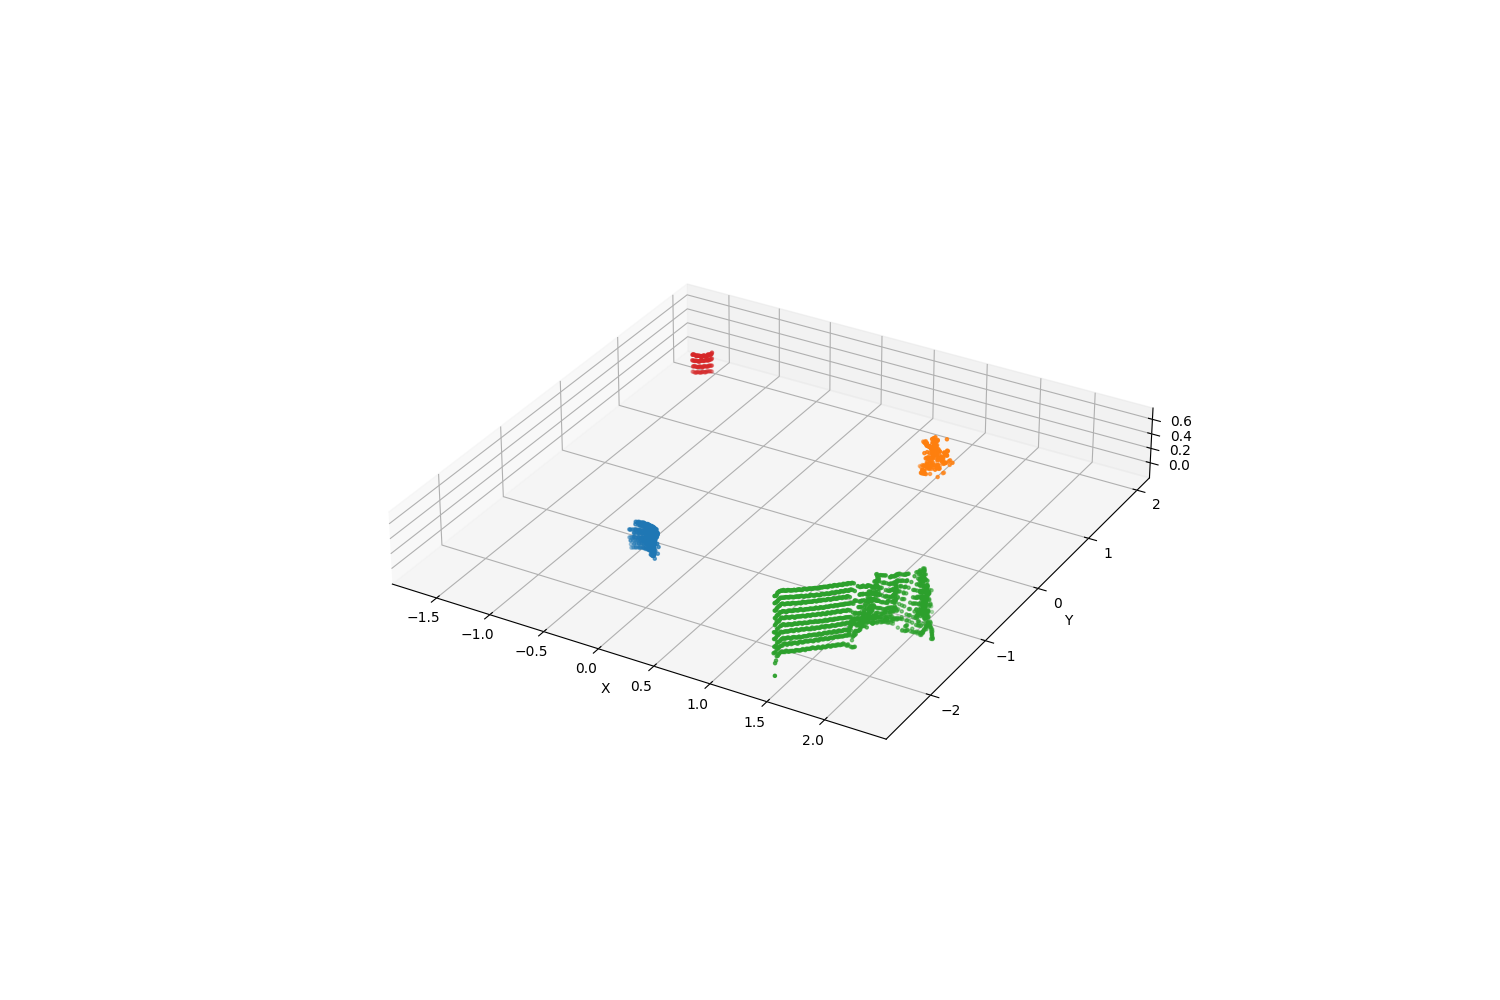

In [14]:
# Plot
ax = plot_3D_setup(P_filter)

color_idx = 0

for i, c in enumerate(landmark_clusters):
    cluster_pts = P_filter[c,:]
    ax.scatter3D(cluster_pts[:,0], cluster_pts[:,1], cluster_pts[:,2], color='C'+str(color_idx), marker='.')  
    color_idx += 1

In [ ]:
thetas, phis = spherical_project(P_filter)

In [ ]:
# Color code by distance
dists = np.linalg.norm(P_filter, axis=1)
min_dist = min(dists)
max_dist = max(dists)

In [ ]:
cmap = cm.get_cmap('plasma')
c_idx = list(np.interp(dists, [min_dist, max_dist], [255, 0]).astype(int))
colors = [cmap.colors[i] for i in c_idx]

fig, ax = plt.subplots()
c_idx = np.interp(dists, [min_dist, max_dist], [0, 255]).astype(int)
ax.scatter(thetas, phis, color=colors, s=1, marker='.')

In [ ]:
# Ground-plane removal?
# Background removal?